# New York Propert Prices Analysis

Improving property valuation models has always been an open research question for the scientific community. Many studies  has been published on this topic with various methods and variations proposed to improve accuracy of predictions. Given the Adavnces in Deep learning, there is more space for innovation that ever before. 

As we know, value of a property can be determined by many other subtle factors, not only by house specific or neighbourhood specific metrics, for example by infrastructure or safety of the neighbourhood. 

This project is somehow novel as it tries to incorporate contextual information extracted from satellite images in traditional  property valuation models, and then study and quantify the effects of such a combination.


In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error
  

Two datatsets have been considered during the analysis: the New York property prices dataset containing house specific, location specific and neighbourhood specific metrics and a second dataset consisting of features extracted from satellite images using CNNs.

In [2]:
#load first dataset
data=pd.read_csv('sales_data_2015.csv')
pd.set_option('display.max_columns', None)
data.head()

C:\Users\Laurentia\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Sale_id,bbl_id,year,borough,bldg_ctgy,tax_cls_p,block,lot,easmnt,bldg_cls_p,address,apt,zip,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,sale_date,price,usable,long,lat
0,0,1,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,A9,1665 WASHINGTON AVENUE,NaN,10457,1,0,1,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
1,1,2,2290528,2015,2,01 ONE FAMILY DWELLINGS,1,2905,28,NaN,A9,1665 WASHINGTON AVENUE,NaN,10457,1,0,1,4750,2619,1899,1,A9,08-07-15,0,N,-73.901338,40.841229
2,2,3,230352,2015,2,01 ONE FAMILY DWELLINGS,1,3035,2,NaN,S1,441 EAST 178 STREET,NaN,10457,1,1,2,1287,2528,1899,1,S1,12/18/2015,0,N,-73.898331,40.848648
3,3,4,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,S1,455 EAST 184 STREET,NaN,10458,1,1,2,2500,2452,1910,1,S1,08/18/2015,0,N,-73.893338,40.856136
4,4,5,2303936,2015,2,01 ONE FAMILY DWELLINGS,1,3039,36,NaN,S1,455 EAST 184 STREET,NaN,10458,1,1,2,2500,2452,1910,1,S1,07-01-15,400000,Y,-73.893338,40.856136


## Data Cleaning

In the first step of the project, data cleaning has been conducted on the first dataset.

In [3]:
#check column names
data.columns

Index(['Unnamed: 0', 'Sale_id', 'bbl_id', 'year', 'borough', 'bldg_ctgy',
       'tax_cls_p', 'block', 'lot', 'easmnt', 'bldg_cls_p', 'address', 'apt',
       'zip', 'res_unit', 'com_unit', 'tot_unit', 'land_sqft', 'tot_sqft',
       'yr_built', 'tax_cls_s', 'bldg_cls_s', 'sale_date', 'price', 'usable',
       'long', 'lat'],
      dtype='object')

In [4]:
#check shape
data.shape

(84768, 27)

In [5]:
# missing values function
def missing_data(frame):
    total = frame.isnull().sum().sort_values(ascending=False)
    percent = (frame.isnull().sum()/frame.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
# check for missing values in data
missing_data(data)

,Total,Percent
easmnt,84767,99.998820
apt,63785,75.246555
tax_cls_p,3,0.003539
bldg_cls_p,3,0.003539
lat,0,0.000000
Sale_id,0,0.000000
bbl_id,0,0.000000
year,0,0.000000
borough,0,0.000000
bldg_ctgy,0,0.000000


In [6]:
#remove column 'easmnt' and'apt' as they consist of too many missing values
#also remove 'unnamed' as it only indicates order
#remove column year as it only represents the year when the data was collected- all values are '2015'
data=data.drop(['easmnt','apt','Unnamed: 0', 'year'], axis=1)

In [7]:
#remove the 3 rows with missing data
data=data.dropna(axis=0, how='all', subset=['tax_cls_p', 'bldg_cls_p'])

In [8]:
#drop duplicates
data=data.drop_duplicates()

In [9]:
# check entries which are 0---presumably a missing entry
print("Entries with incorrect year built: ", len(data[data.yr_built == 0]))
print("Entries with incorrect block: ", len(data[data.block == 0]))
print("Entries with incorrect lot: ", len(data[data.lot == 0]))
print("Entries with incorrect zip: ", len(data[data.zip == 0]))
print("Entries with incorrect land_sqft: ", len(data[data.land_sqft == 0]))   
print("Entries with incorrect totsqft: ", len(data[data.tot_sqft == 0]))
print("Entries with incorrect price: ",len(data[data.price == 0]))
print("Original dataset length: ",len(data))


Entries with incorrect year built:  6527
Entries with incorrect block:  0
Entries with incorrect lot:  0
Entries with incorrect zip:  50
Entries with incorrect land_sqft:  38201
Entries with incorrect totsqft:  40636
Entries with incorrect price:  24116
Original dataset length:  84765


In [10]:
#choose only rows with valid entries
data = data[(data.yr_built != 0) & (data.zip != 0)& (data.land_sqft != 0)
            & (data.tot_sqft != 0) & (data.price != 0)]
print("Cleaned dataset length: ", len(data))

Cleaned dataset length:  28703


In [11]:
#check data types
#data.dtypes

In [12]:
#transform data types accordingly
data['sale_date']= pd.to_datetime(data['sale_date'])

In [13]:
#check values of categorical variables
print('borough:', data.borough.unique())
print('bldg_ctgy', data.bldg_ctgy.unique())
print('tax_cls_p', data.tax_cls_p.unique())
print('bldg_cls_p', data.bldg_cls_p.unique())
print('tax_cls_s', data.tax_cls_s.unique())
print('bldg_cls_s',data.bldg_cls_s.unique())
print('usable',data.usable.unique())

borough: [2 3 1 4 5]
bldg_ctgy ['01  ONE FAMILY DWELLINGS' '02  TWO FAMILY DWELLINGS'
 '03  THREE FAMILY DWELLINGS' '07  RENTALS - WALKUP APARTMENTS'
 '21  OFFICE BUILDINGS' '22  STORE BUILDINGS' '27  FACTORIES'
 '29  COMMERCIAL GARAGES' '31  COMMERCIAL VACANT LAND'
 '32  HOSPITAL AND HEALTH FACILITIES' '30  WAREHOUSES'
 '08  RENTALS - ELEVATOR APARTMENTS' '14  RENTALS - 4-10 UNIT'
 '37  RELIGIOUS FACILITIES' '41  TAX CLASS 4 - OTHER'
 '05  TAX CLASS 1 VACANT LAND' '35  INDOOR PUBLIC AND CULTURAL FACILITIES'
 '36  OUTDOOR RECREATIONAL FACILITIES' '09  COOPS - WALKUP APARTMENTS'
 '10  COOPS - ELEVATOR APARTMENTS' '11A CONDO-RENTALS'
 '38  ASYLUMS AND HOMES' '33  EDUCATIONAL FACILITIES' '34  THEATRES'
 '06  TAX CLASS 1 - OTHER' '11  SPECIAL CONDO BILLING LOTS'
 '23  LOFT BUILDINGS' '39  TRANSPORTATION FACILITIES' '25  LUXURY HOTELS'
 '26  OTHER HOTELS' '13  CONDOS - ELEVATOR APARTMENTS'
 '40  SELECTED GOVERNMENTAL FACILITIES' '17  CONDO COOPS']
tax_cls_p ['1' '2B' '2' '4' '2A' '1D' '2C']

In [14]:
#transform categorical data accordingly
#use label encoding as we have too many categories to do one hot encoding
data['borough']=data['borough'].astype('category')
data['borough']=data['borough'].cat.codes
data['bldg_ctgy']=data['bldg_ctgy'].astype('category')
data['bldg_ctgy']=data['bldg_ctgy'].cat.codes
data['tax_cls_p']=data['tax_cls_p'].astype('category')
data['tax_cls_p']=data['tax_cls_p'].cat.codes
data['bldg_cls_p']=data['bldg_cls_p'].astype('category')
data['bldg_cls_p']=data['bldg_cls_p'].cat.codes
data['tax_cls_s']=data['tax_cls_s'].astype('category')
data['tax_cls_s']=data['tax_cls_s'].cat.codes
data['bldg_cls_s']=data['bldg_cls_s'].astype('category')
data['bldg_cls_s']=data['bldg_cls_s'].cat.codes
data['usable']=data['usable'].astype('category')
data['usable']=data['usable'].cat.codes



Location specific attributes like zip or latitude have been removed as it has been considered that this information is already embedded in neighbourhood data or image features. 

In [15]:
#drop location data: address column, lat,long,zip, borough 
#We will not need location info in this first step of our analysis

data=data.drop(['address','lat', 'long','zip', 'borough'], axis=1)


In [16]:
#drop temporal data to be able to perform further statistical analysis
data=data.drop(['sale_date'], axis=1)

In [17]:
data.shape

(28703, 17)

In [18]:
data.head()

,Sale_id,bbl_id,bldg_ctgy,tax_cls_p,block,lot,bldg_cls_p,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,price,usable
4,5,2303936,0,0,3039,36,115,1,1,2,2500,2452,1910,0,118,400000,1
7,8,22912139,1,0,2912,139,10,2,0,2,2000,2400,1993,0,10,430000,1
8,9,22912152,1,0,2912,152,10,2,0,2,2000,2400,1993,0,10,10000,1
9,10,22929126,1,0,2929,126,10,2,0,2,3165,2394,1995,0,10,505000,1
10,11,23030151,1,0,3030,151,116,2,1,3,1620,3240,1931,0,119,490000,1


To remove outliers in the dataset, an upper and lower bound has been set for the price. Entries with price lower than $100,000 have been removed(lower bound) along with entries where price deviated more than one standard deviation from the mean(upper bound). 2600 entries have been removed this way, so 3% of the original data. The choice have been made after computing statistical summaries of the data and after consulting existing literature.

In [19]:
#set lower bound for price, land_sqft,tot_sqft
data=data.drop(data.index[(data['price'] < 100000)])
data=data.drop(data.index[(data['tot_sqft'] < 470)])
data=data.drop(data.index[(data['land_sqft'] < 1300)])

In [20]:
data.shape

(26097, 17)

In [22]:
#removing outliers by excluding all sampleswhere price deviates more than 2 standard deviation from the mean. Due to the highly right-skewed
#similarly to setting an upper bound for the price and discarding houses with extremely high prices
from scipy import stats
data=data[((data.price - data.price.mean()) / data.price.std()).abs() < 1]

In [23]:
data.shape

(25498, 17)

As a result of data cleaning 14 features have been considered for modelling. However, further statistical analysis could have been done in order to remove more of the less informative variables.

## Data Splitting

In [24]:
# prepare data for modelling
X = data.drop(columns=['Sale_id', 'bbl_id','price'])
Y = data.price
Y = np.array(Y).reshape(-1)
print(X.shape,Y.shape)

(25498, 14) (25498,)


In [25]:
#split data into 80/10/10--- training/validation/test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .20, random_state = 40)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size = 0.5)
X_train.shape, X_test.shape, X_val.shape

((20398, 14), (2550, 14), (2550, 14))

## Modeling

When considering modelling, first thing to do was checking linarity assumptions in the cleaned dataset and determine what kind of models should be considered for better predictions: **linear** or **non-linear**.

Fitting linear regression

R^2: 0.33690004587342437 

Coefficients
-------------------------------------
Intercept: 9119189.290196145
X1: -56598.73118919958
X2: -691179.4744339513
X3: -58.212915127629536
X4: -83.74379482310789
X5: 10642.133906346406
X6: 56264.34261232165
X7: 116928.60080686603
X8: -17443.434397162524
X9: 27.15840977642083
X10: -9.898458373176183
X11: -4215.444771997622
X12: 3521135.5169963464
X13: -8999.481704774416
X14: 0.0

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


C:\Users\Laurentia\anaconda3\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


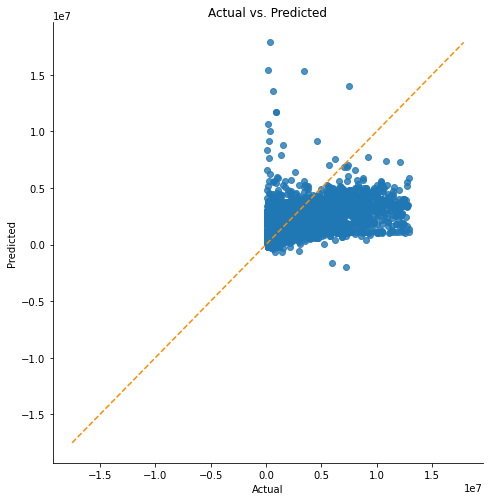

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


C:\Users\Laurentia\anaconda3\lib\site-packages\statsmodels\stats\_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


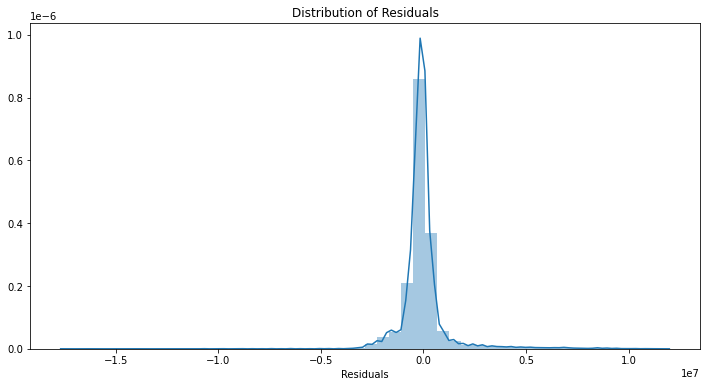


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.1173183604987114
Signs of positive autocorrelation 

Assumption not satisfied 

Consider adding lag variables


In [26]:
#checking linear assumptions
def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    from sklearn.linear_model import LinearRegression
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    print()
    print('R^2:', r2, '\n')
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
   
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
   
    linear_assumption()
    normal_errors_assumption()
    autocorrelation_assumption()
    

linear_regression_assumptions(X, Y)

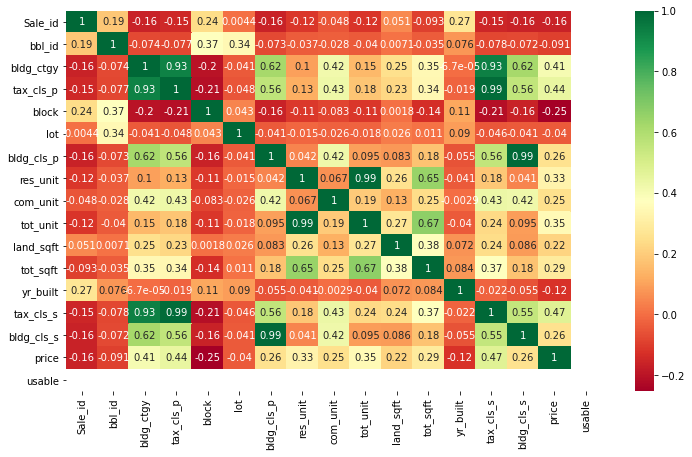

In [27]:
#check correlation between variables in order to detect collinearity
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(12,7))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [28]:
#further check for collinearity using VIF
#VIF of >5 indicates serious collinearity

# the independent variables set 
X = data.drop(columns=['Sale_id', 'bbl_id'])
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

       feature          VIF
0    bldg_ctgy     9.660295
1    tax_cls_p    55.708106
2        block     1.110173
3          lot     1.013207
4   bldg_cls_p    85.000726
5     res_unit  2187.371296
6     com_unit    39.255653
7     tot_unit  2263.294326
8    land_sqft     1.232027
9     tot_sqft     2.229351
10    yr_built     1.065371
11   tax_cls_s    63.995450
12  bldg_cls_s    84.852987
13       price     1.508068
14      usable  4388.969868


The assumptions of linearity are clearly violated. There is very little linear relationships between target and feature variables, error terms are not normally distributed and the heatmap signals high collinearity issues, with values of Variance Inflation Factor(VIF) confirming that. 


In [29]:
#final dataset to be considered for modelling
data.head()

,Sale_id,bbl_id,bldg_ctgy,tax_cls_p,block,lot,bldg_cls_p,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,price,usable
4,5,2303936,0,0,3039,36,115,1,1,2,2500,2452,1910,0,118,400000,1
7,8,22912139,1,0,2912,139,10,2,0,2,2000,2400,1993,0,10,430000,1
9,10,22929126,1,0,2929,126,10,2,0,2,3165,2394,1995,0,10,505000,1
10,11,23030151,1,0,3030,151,116,2,1,3,1620,3240,1931,0,119,490000,1
12,13,23030203,1,0,3030,203,12,2,0,2,1592,1860,1899,0,12,100000,1


Following the conclusions made in the linearity assumption check, only non-linear models have been chosen for modelling: **Decision Trees**, **Random Forest** and **XGBoost**. 

All models have been evaluated using **Mean Absolute Error**. Also, they were compared with a baseline which in this case was the Mean absolute error calculated using the mean price of all houses as a prediction with a values of **$811k**.
By comparing the results against the error of this random prediction, one can assess the predictive power of the models. 

In [30]:
#baseline for model comparison, in this case the mean of a random prediction
abs(y_test - y_test.mean()).mean()

811368.1264313724

First part of the experiment was done on the  dataset containing property and neighbourhood features. 

Models have been intialized first with hand-picked parameters, trained on the training set and tested on the validation set in order to further tune hyperparameters.  

In [31]:
#initialize model
dt=DecisionTreeRegressor(min_samples_split=5, max_features=6, random_state=0)

#fit the model
model=dt.fit(X_train, y_train)

# calculate R^2 scores
print('Train:', model.score(X_train, y_train))
print('Validation:', model.score(X_val, y_val))

#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model.predict(X_test)))

Train: 0.9487174098071539
Validation: 0.411281164035165
MAE: 490891.39560392156


To increase the chances of quickly finding better hyperparameters, scikitlearn‘s *GridSearchCV* and *RandomizedSearchCV* modules have been used.

In [32]:
#GridSearch for decision trees
#dt=DecisionTreeRegressor()
#parameters = {'criterion':['mse', 'friedman_mse', 'mae'], 'max_depth':[2,4,7,9, 25], 
#              'max_features':[3,5,7,10], 
#              'min_samples_split':[3,4,6,9]}
#search = GridSearchCV(dt, parameters, verbose=4, n_jobs=-1, scoring='neg_mean_absolute_error')
#search.fit(X_train, y_train)
#search.best_params_

In [33]:
#initialize tuned model
dt_new=DecisionTreeRegressor(criterion= 'mae',max_depth= 9,
                            max_features=10 ,min_samples_split= 4)

#fit the model
model_1=dt_new.fit(X_train, y_train)

# calculate R^2 scores
print('Train:', model_1.score(X_train, y_train))
print('Validation:', model_1.score(X_val, y_val))

#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_1.predict(X_test)))

Train: 0.6859238442673171
Validation: 0.5136723510537439
MAE: 422043.1398039216


In [34]:
#initialize model
rf=RandomForestRegressor(max_features=5, n_estimators=300, n_jobs=-1)

#fit the model
model_2=rf.fit(X_train, y_train)

# calculate R^2 scores
print('Train:', model_2.score(X_train, y_train))
print('Validation:', model_2.score(X_val, y_val))


#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_2.predict(X_test)))

Train: 0.9522025632800991
Validation: 0.6661030005441197
MAE: 381941.5788505005


In [35]:
#finding best parameters with RandomizedSearchCV 
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
#print(random_grid)

In [36]:
# Use the random grid to search for best hyperparameters
#rf=RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_jobs = 10, cv = 3, verbose=2,
#                              scoring='neg_mean_absolute_error')
# Fit the random search model
#rf_random.fit(X_train, y_train)
#rf_random.best_params_

In [37]:
#run model with parameters found in the RandomizedSearch

#initialize model
rf_new=RandomForestRegressor(n_estimators=1600, 
                               min_samples_split=10,
                               min_samples_leaf= 4,
                               max_features= 'auto',
                               max_depth= 50,
                               bootstrap= True)

#fit the model
model_3=rf_new.fit(X_train, y_train)

# calculate R^2 scores
print('Train:', model_3.score(X_train, y_train))
print('Validation:', model_3.score(X_val, y_val))

#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_3.predict(X_test)))

Train: 0.8490591326373816
Validation: 0.6646511622219391
MAE: 384840.22174569906


In [38]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [39]:
#test another algorithm

#initialize model
xg_reg = XGBRegressor(eta=0.05, max_depth=6,gamma=0.2,subsample=0.7)

#fit the model
model_4=xg_reg.fit(X_train,y_train)

# calculate R^2 scores
print('Train:', model_4.score(X_train, y_train))
print('Validation:', model_4.score(X_val, y_val))


#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_4.predict(X_test)))

Train: 0.7960803944664537
Validation: 0.6524977398156511
MAE: 407133.3068872549


In [40]:
#GridSearch for xgboost
#xg_reg = XGBRegressor()
#parameters = {'eta':[0.05,0.1,0.2], 'max_depth':[7,9, 25,40], 'gamma':[0, 0.1, 0.2], 
#              'subsample':[0.1,0.5,0.7],'colsample_bytree':[0.5,0.7,1]}
#search = GridSearchCV(xg_reg, parameters, verbose=2, n_jobs=-1, scoring='neg_mean_absolute_error')
#search.fit(X_train, y_train)
#search.best_params_

In [41]:
#test model after parameter tuning

#initialize model
xg_reg_new = XGBRegressor(colsample_bytree=0.7,
                            eta=0.05,
                            gamma=0,
                            max_depth= 25,
                            subsample=0.7)

#fit the model
model_5=xg_reg_new.fit(X_train,y_train)

# calculate R^2 scores
print('Train:', model_5.score(X_train, y_train))
print('Validation:', model_5.score(X_val, y_val))

#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_5.predict(X_test)))

Train: 0.9888558312801499
Validation: 0.6518980568959383
MAE: 381698.041908701


Next, the first dataset has been combined with the dataset containing features extracted from images.  Same techniques have been applied for data splitting, parameter tuning and model selection as in the first part of the experiment.

In [42]:
#import dataset including features extracted from aerial photos
image_data=pd.read_csv('sales_data_2015_DF-inception-conv.csv')
image_data=image_data.drop(['Unnamed: 0', 'bbl_id'], axis=1)
image_data.head()

,Sale_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,1,0.141194,0.421060,0.466694,-0.989387,0.091223,1.033919,-0.001966,-0.098034,-0.159921,0.023693,-0.424309,0.037332,-0.036936,0.114200,-0.056193,-0.450069,-0.681964,0.029796,0.089412,0.019512,0.033488,-0.163477,0.600213,-0.493792,-0.047002,-0.092415,0.427163,0.688372,-0.549481,-0.538056,0.358792,-0.103146
1,2,0.141194,0.421060,0.466694,-0.989387,0.091223,1.033919,-0.001966,-0.098034,-0.159921,0.023693,-0.424309,0.037332,-0.036936,0.114200,-0.056193,-0.450069,-0.681964,0.029796,0.089412,0.019512,0.033488,-0.163477,0.600213,-0.493792,-0.047002,-0.092415,0.427163,0.688372,-0.549481,-0.538056,0.358792,-0.103146
2,3,0.114756,0.350338,0.387500,-0.834070,0.063190,0.863413,-0.001232,-0.084781,-0.131445,0.011075,-0.356321,0.030225,-0.031919,0.095055,-0.054910,-0.377809,-0.561407,0.013183,0.076345,0.016472,0.029367,-0.137302,0.502646,-0.414158,-0.037535,-0.060672,0.358382,0.585332,-0.458778,-0.447776,0.301268,-0.086599
3,4,0.114901,0.351911,0.388062,-0.835415,0.068941,0.867273,-0.001948,-0.082643,-0.133502,0.016002,-0.355564,0.028320,-0.028222,0.096733,-0.051392,-0.378535,-0.565638,0.016828,0.074499,0.014374,0.028011,-0.136841,0.503530,-0.413901,-0.038112,-0.066762,0.358489,0.580582,-0.461086,-0.449793,0.301751,-0.086144
4,5,0.114901,0.351911,0.388062,-0.835415,0.068941,0.867273,-0.001948,-0.082643,-0.133502,0.016002,-0.355564,0.028320,-0.028222,0.096733,-0.051392,-0.378535,-0.565638,0.016828,0.074499,0.014374,0.028011,-0.136841,0.503530,-0.413901,-0.038112,-0.066762,0.358489,0.580582,-0.461086,-0.449793,0.301751,-0.086144


In [43]:
data=data.drop(['bbl_id'], axis=1)

In [44]:
#merge with data
complete_dataset=data.join(image_data.set_index('Sale_id'), on='Sale_id', how='inner')
complete_dataset.head()

,Sale_id,bldg_ctgy,tax_cls_p,block,lot,bldg_cls_p,res_unit,com_unit,tot_unit,land_sqft,tot_sqft,yr_built,tax_cls_s,bldg_cls_s,price,usable,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
4,5,0,0,3039,36,115,1,1,2,2500,2452,1910,0,118,400000,1,0.114901,0.351911,0.388062,-0.835415,0.068941,0.867273,-0.001948,-0.082643,-0.133502,0.016002,-0.355564,0.028320,-0.028222,0.096733,-0.051392,-0.378535,-0.565638,0.016828,0.074499,0.014374,0.028011,-0.136841,0.503530,-0.413901,-0.038112,-0.066762,0.358489,0.580582,-0.461086,-0.449793,0.301751,-0.086144
7,8,1,0,2912,139,10,2,0,2,2000,2400,1993,0,10,430000,1,0.105824,0.327731,0.363355,-0.803895,0.027193,0.820350,0.000975,-0.076084,-0.116712,-0.015371,-0.343971,0.033535,-0.043393,0.089633,-0.072723,-0.363858,-0.511580,-0.012120,0.069690,0.015504,0.026007,-0.130096,0.479302,-0.395842,-0.036620,-0.021969,0.343046,0.584889,-0.432926,-0.418085,0.292563,-0.083255
9,10,1,0,2929,126,10,2,0,2,3165,2394,1995,0,10,505000,1,0.099142,0.281637,0.324657,-0.735360,-0.052358,0.733772,0.009683,-0.071737,-0.079713,-0.083412,-0.322006,0.058767,-0.093172,0.086124,-0.114585,-0.340659,-0.397580,-0.056874,0.064852,0.019137,0.023473,-0.117101,0.430004,-0.356712,-0.033778,0.052749,0.310742,0.591258,-0.378233,-0.359148,0.278349,-0.079215
10,11,1,0,3030,151,116,2,1,3,1620,3240,1931,0,119,490000,1,0.109671,0.344990,0.379070,-0.827211,0.057249,0.851783,-0.001726,-0.079784,-0.129961,0.009346,-0.352575,0.026218,-0.027492,0.093221,-0.056978,-0.372965,-0.553889,0.006184,0.073003,0.016288,0.026285,-0.134310,0.496972,-0.410028,-0.038340,-0.051503,0.355177,0.582540,-0.452473,-0.440415,0.297595,-0.084592
12,13,1,0,3030,203,12,2,0,2,1592,1860,1899,0,12,100000,1,0.123555,0.348343,0.392670,-0.828119,0.054881,0.865405,0.002025,-0.084293,-0.124857,-0.002824,-0.358418,0.044963,-0.054176,0.097571,-0.061078,-0.381223,-0.548658,0.016411,0.075841,0.016770,0.028896,-0.137105,0.500884,-0.411415,-0.038842,-0.061672,0.356419,0.593118,-0.456660,-0.445535,0.306040,-0.088525


In [45]:
#preparing the new dataset for modelling
X = complete_dataset.drop(columns=['Sale_id', 'price'])
Y = complete_dataset.price
Y = np.array(Y).reshape(-1)

#split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .20, random_state = 40)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size = 0.5,train_size =0.5)


In [46]:
#initialize model
dt=DecisionTreeRegressor(min_samples_split=5, max_features=6, random_state=0)

#fit the best model
model_6=dt.fit(X_train,y_train)

# calculate R^2 scores
print('Train:', model_6.score(X_train, y_train))
print('Validation:', model_6.score(X_val, y_val))

print('MAE:', mean_absolute_error(y_test, model_6.predict(X_test)))

Train: 0.9503915421693395
Validation: 0.3524945669957442
MAE: 536808.0650825875


In [47]:
#GridSearch for decision trees
#dt=DecisionTreeRegressor()
#parameters = {'criterion':['mse', 'friedman_mse', 'mae'], 'max_depth':[2,4,7,9, 25], 
#              'max_features':[3,5,7,10], 
#              'min_samples_split':[3,4,6,9]}

#search = GridSearchCV(dt, parameters, verbose=4, n_jobs=-1, scoring='neg_mean_absolute_error')
#search.fit(X_train, y_train)
#search.best_params_

In [48]:
#initialize tuned model
dt_new=DecisionTreeRegressor(criterion= 'mae',max_depth= 9,
                            max_features=10 ,min_samples_split= 6)

#fit the model
model_7=dt_new.fit(X_train, y_train)

# calculate R^2 scores
print('Train:', model_7.score(X_train, y_train))
print('Validation:', model_7.score(X_val, y_val))

#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_7.predict(X_test)))

Train: 0.6697830969599854
Validation: 0.560592122970706
MAE: 457501.67931576876


In [49]:
#fit the random forest regressor to the new dataset 
model_8=rf.fit(X_train, y_train)

# calculate R^2 scores
print('Train:', model_8.score(X_train, y_train))
print('Validation:', model_8.score(X_val, y_val))


#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_8.predict(X_test)))

Train: 0.9514118508692133
Validation: 0.6975054412661555
MAE: 401058.43776499317


In [50]:
# Use the random grid to search for best hyperparameters
#rf=RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_jobs = 10, cv = 3, verbose=2,
#                              scoring='neg_mean_absolute_error')
# Fit the random search model
#rf_random.fit(X_train, y_train)
#rf_random.best_params_

In [51]:
#run model with parameters found in the RandomizedSearch

#initialize model
rf_new=RandomForestRegressor(n_estimators=1400, 
                               min_samples_split=2,
                               min_samples_leaf= 4,
                               max_features= 'auto',
                               max_depth= None,
                               bootstrap= True)

#fit the model
model_9=rf_new.fit(X_train, y_train)

# calculate R^2 scores
print('Train:', model_9.score(X_train, y_train))
print('Validation:', model_9.score(X_val, y_val))

#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_9.predict(X_test)))

Train: 0.8936723092100584
Validation: 0.7499038284506474
MAE: 363409.249718075


In [52]:
#fit xgbregressor to new datsaet 
model_10=xg_reg.fit(X_train,y_train)

# calculate R^2 scores
print('Train:', model_10.score(X_train, y_train))
print('Validation:', model_10.score(X_val, y_val))


#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_10.predict(X_test)))

Train: 0.8412208679125738
Validation: 0.7367639145166132
MAE: 386647.053197503


In [53]:
#GridSearch for xgboost
#from sklearn.model_selection import GridSearchCV
#xg_reg = XGBRegressor()
#parameters = {'eta':[0.05,0.1,0.2], 'max_depth':[7,9, 25,40], 'gamma':[0, 0.1, 0.2], 
#              'subsample':[0.1,0.5,0.7],'colsample_bytree':[0.5,0.7,1]}
#search = GridSearchCV(xg_reg, parameters, verbose=2, n_jobs=-1, scoring='neg_mean_absolute_error')
#search.fit(X_train, y_train)
#search.best_params_

In [54]:
#test model after parameter tuning

#initialize model
xg_reg_new = XGBRegressor(colsample_bytree=0.7,
                            eta=0.05,
                            gamma=0,
                            max_depth= 25,
                            subsample=0.7)

#fit the model
model_11=xg_reg_new.fit(X_train,y_train)

# calculate R^2 scores
print('Train:', model_11.score(X_train, y_train))
print('Validation:', model_11.score(X_val, y_val))

#calculate MAE for model comparison
print('MAE:', mean_absolute_error(y_test, model_11.predict(X_test)))

Train: 0.9922053655894255
Validation: 0.7329380996442503
MAE: 363812.3595562574


In the last part of the analysis, only the models which performed best on validation data have been chosen to be tested on the ‘unseen’ test set. The Mean absolute error has been computed and used as a guideline for model comparison.

The results are summarized in the table below.


|Model| Analysis I| Analysis II|
|----|-----|-----|
| Decision Trees| 422043 *(-47,98%)*| 457501 *(-43,60%)*|
| Random Forest| 381941*(-52,93%)*| 363409 *(-50,57%)*|
| XGBoost| 381698*(-52,95%)*| 363812 *(-55,16%)*|

The results can be interpreted as follows: using the DecisionTreeRegressor on the first dataset alone reduces the mean absolute error with 47% compared to the baseline, while using it on the combined dataset, reduces it with 43%. The percentage result in the parenthesis shows by how much the MAE has been reduced compared to the baseline when using the specific model.

The difference between the baseline and these models is considerable, however, if looking at differences in MAE between models with and without the image features, one can see that the improvement is not significant, and even in the case of DecisionTreeRegressor the MAE is slightly higher for the combined dataset. 

## Conclusion

The analysis have not found significant improvement in model performance when combining property and neighbourhood information with features extracted from aerial photos and a reason for that could be that the contextual information from image features was already embedded in the neighbourhood features.

Thus, this analysis doesn’t imply that image feature are not important when trying to predict property prices, they could actually be very powerful if combined with porperty information only. This is assumption can be studies in a future analysis.
